In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

In [ ]:
class Car(object):
    def __init__(self):
        self.track = pd.read_csv('https://raw.githubusercontent.com/KnowchowHQ/rl-in-action/master/C1-RL-Intro/W1S1/track.txt',sep=' ')
        self.kdtree = KDTree(self.track)
        self.__reset__()

    def __reset__(self):
        self.max_steering_deg = 25
        self.min_steering_deg = -25
        self.min_speed = 0 #meter per second
        self.max_speed = 50 #meter per second
        self.speed = 0 #meter per second
        self.steering_deg = 0 #degree
        self.heading_deg = 0 #degrees
        self.x = self.track.x[0]
        self.y = self.track.y[0]
        self.length = 1.0 # length of vehicle in meter
        self.trip_length = 0.0 #meters
        
    def render(self):
        plt.figure(figsize=(12,8))
        plt.scatter(self.track.x, self.track.y)
        plt.plot(self.track.x[0], self.track.y[0], 'go', markersize=12)
        plt.plot(self.x, self.y, 'r.', markersize=12)
        plt.show()
        
    
    def _to_rad_(deg):
        return deg * np.pi / 180
    
    def _to_deg_(rad):
        return rad*180/np.pi
    
    def __check_off_track__(self):
        dist, ind = self.kdtree.query([[self.x, self.y]], 1)
        car = (round(self.x,2), round(self.y,2))
        closest_x = float(self.track.x[ind[0]])
        closest_y = float(self.track.y[ind[0]])
        closest = (round(closest_x,2),round(closest_y,2))
        assert dist <= 15,\
        f"Game Over!! Your car veered off the track after {self.trip_length}m! Car:{car} Closest Point:{closest}"
    
    def move(self, time_step):
        heading = Car._to_rad_(self.heading_deg)
        steering = Car._to_rad_(self.steering_deg)
        
        delta_x = self.speed*np.cos(heading)*time_step
        delta_y = self.speed*np.sin(heading)*time_step
        self.x = self.x + delta_x
        self.y = self.y + delta_y
     
        new_heading = (heading + self.speed / self.length * steering * time_step) % (np.pi * 2)
        if new_heading > np.pi:
            new_heading = new_heading - 2*np.pi
        elif new_heading < -np.pi:
            new_heading = 2*np.pi - new_heading
            
        self.heading_deg = Car._to_deg_(new_heading)
        
        self.trip_length += np.sqrt(delta_x**2 + delta_y**2)
        
        self.__check_off_track__()
    
        
    
    def set_steering(self, steer_deg):
        assert self.min_steering_deg <= steer_deg <= self.max_steering_deg,\
        f'Steering angle must be in degree and in the range {self.min_steering_deg},{self.max_steering_deg}'
        
        self.steering_deg = steer_deg
        
        
    def set_speed(self, speed_meter_sec):
        assert self.min_speed <= speed_meter_sec <= self.max_speed,\
        (f'Speed must be in meters per second and in the range {self.min_speed},{self.max_speed}')
        
        self.speed = speed_meter_sec
        
        
    
    def find_nearest_track_points(self,n=5):
        dist, inds = self.kdtree.query([[self.x, self.y]], 3)
        closest_inds = inds[0][0]
        return self.track.iloc[closest_inds:closest_inds+n]
        

In [ ]:
car = Car()

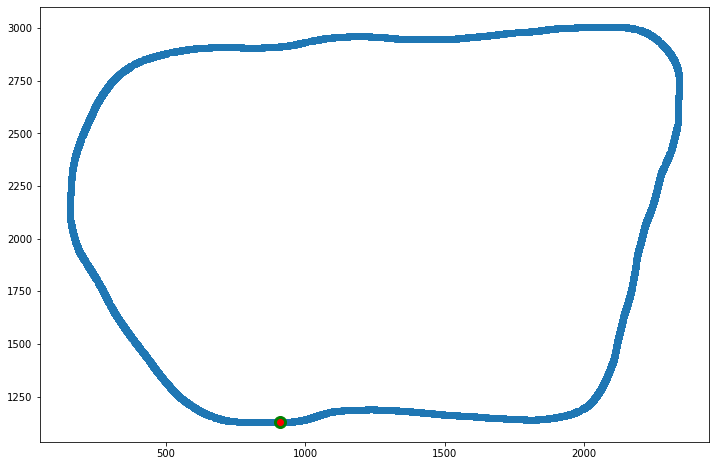

In [ ]:
car.render()

73 steps.
Game Over!! Your car veered off the track after 148.0m! Car:(1056.07, 1147.59) Closest Point:(1050.24, 1161.62)


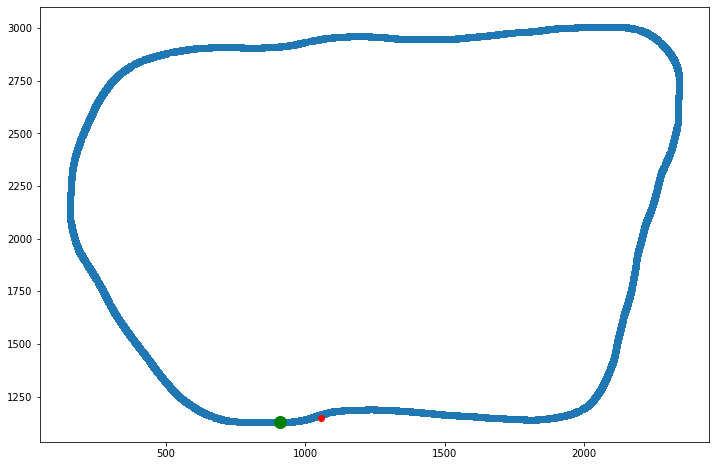

In [ ]:
car.__reset__()
car.set_speed(20)
car.set_steering(0.1)

try:
    for i in range(150):
        car.move(.1)
except Exception as err:
    print(f'{i} steps.')
    print(err)
finally:
    car.render()

In [ ]:
Kp=0.005
Kd=0.05
Ki=0.0000

3400 steps.


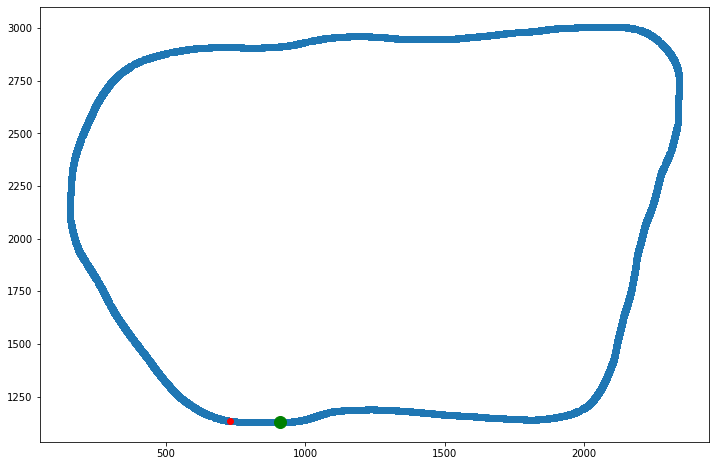

In [ ]:
car.__reset__()
car.set_speed(20)
car.set_steering(0.1)

trajectory = []
controls = []
debug_log = {'desired_heading':[], 'current_heading':[], 'error':[], 'coeff':[], 'nearest_x':[], 'nearest_y':[]}
prev_error = 0
cuml_error = 0

try:
    for i in range(3400):
        nearest = car.find_nearest_track_points()
        #coeffs = np.polyfit(nearest.x, nearest.y, 1)

        delta_x = nearest.x.iloc[-1]-nearest.x.iloc[0]
        delta_y = nearest.y.iloc[-1]-nearest.y.iloc[0]
        desired_heading = Car._to_deg_(np.arctan2(delta_y, delta_x))

        current_heading = car.heading_deg
        error = (current_heading - desired_heading)
        
        if error > 180:
            error = error - 360
        elif error < -180:
            error = 360 + error
        
        debug_log['desired_heading'].append(desired_heading)
        debug_log['current_heading'].append(current_heading)
        debug_log['error'].append(error)
        debug_log['coeff'].append(coeffs[0])
        debug_log['nearest_x'].append(list(nearest.x))
        debug_log['nearest_y'].append(list(nearest.y))
        
        cuml_error = cuml_error + error
        new_steering_degree = car.steering_deg - Kp*error -Kd*(error - prev_error)-Ki*cuml_error
        prev_error = error
        if new_steering_degree > car.max_steering_deg:
            new_steering_degree = car.max_steering_deg
        elif new_steering_degree < car.min_steering_deg:
            new_steering_degree = car.min_steering_deg
                
        car.set_steering(new_steering_degree)
        trajectory.append((car.x,car.y))
        controls.append(new_steering_degree)
        car.move(.1)
        
        
except Exception as err:
    print(err)
finally:
    print(f'{i+1} steps.')
    car.render()

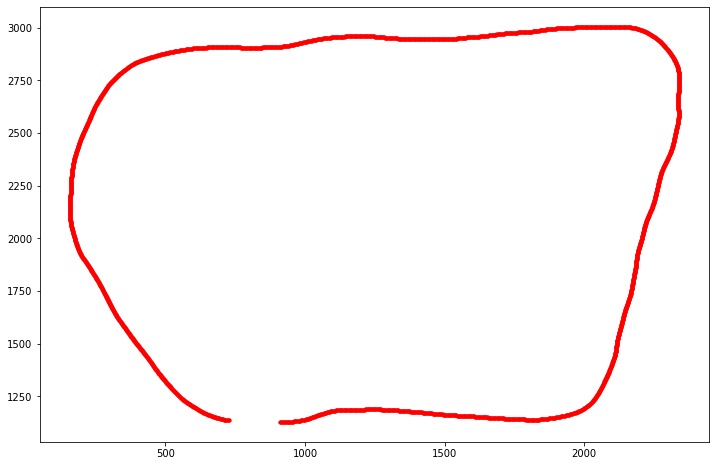

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(*list(zip(*trajectory)),color='r',marker='.')
plt.show()

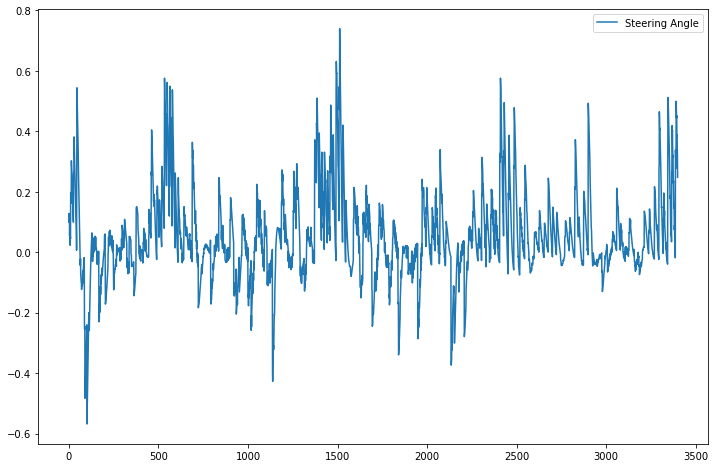

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(controls)
plt.legend(['Steering Angle'])
plt.show()

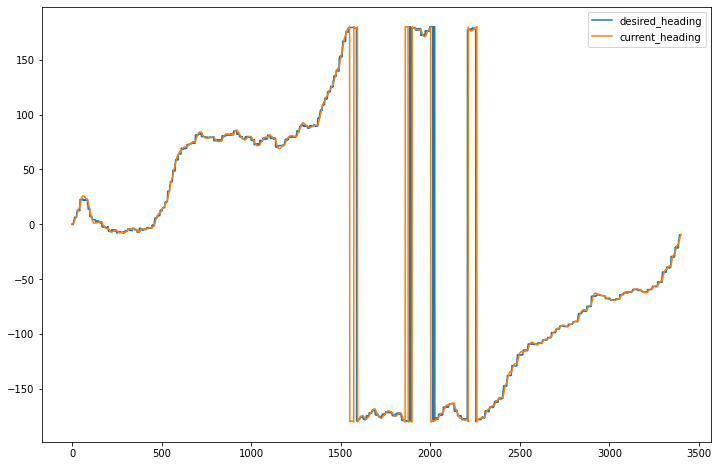

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(debug_log['desired_heading'])
plt.plot(debug_log['current_heading'])
plt.legend(['desired_heading','current_heading'])
plt.show()

In [ ]:
log = pd.DataFrame(debug_log)
log

,desired_heading,current_heading,error,coeff,nearest_x,nearest_y
0,0.000000,0.000000,0.000000,-0.172419,"[909.678, 909.878, 910.078, 910.278, 910.47800...","[1128.84, 1128.84, 1128.84, 1128.84, 1128.84]"
1,0.716160,0.200000,-0.516160,-0.172419,"[911.678, 911.878, 912.078, 912.278, 912.47800...","[1128.85, 1128.86, 1128.86, 1128.86, 1128.86]"
2,0.716160,0.456778,-0.259382,-0.172419,"[913.678, 913.878, 914.078, 914.278, 914.47800...","[1128.87, 1128.87, 1128.87, 1128.88, 1128.88]"
3,0.716160,0.690471,-0.025689,-0.172419,"[915.678, 915.878, 916.078, 916.278, 916.47800...","[1128.89, 1128.89, 1128.89, 1128.89, 1128.9]"
4,0.000000,0.901052,0.901052,-0.172419,"[917.678, 917.878, 918.078, 918.278, 918.47800...","[1128.91, 1128.91, 1128.91, 1128.91, 1128.91]"
...,...,...,...,...,...,...
3395,-10.061825,-11.943432,-1.881606,-0.172419,"[720.0930000000001, 720.29, 720.488, 720.685, ...","[1135.92, 1135.88, 1135.85, 1135.82, 1135.78]"
3396,-9.356306,-11.181260,-1.824953,-0.172419,"[722.065, 722.263, 722.46, 722.6569999999999, ...","[1135.58, 1135.55, 1135.52, 1135.48, 1135.45]"
3397,-9.356306,-10.406503,-1.050197,-0.172419,"[724.0369999999999, 724.235, 724.432, 724.6289...","[1135.25, 1135.22, 1135.18, 1135.15, 1135.12]"
3398,-9.367969,-9.698721,-0.330751,-0.172419,"[726.01, 726.207, 726.404, 726.6010000000001, ...","[1134.92, 1134.88, 1134.85, 1134.82, 1134.79]"
